# Genetic algorithm for hyperparameter optimization on the mnist dataset.
Credits: https://github.com/guibacellar/OpenAi/blob/master/CartPole-GA.py

In [12]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, InputLayer
from keras import backend as K
from keras.utils import to_categorical
from matplotlib import pylot

pyplot.style.use(['dark_background'])

In [107]:
# Define Hyperparameters for NN
HIDDEN_LAYER_COUNT = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
HIDDEN_LAYER_NEURONS = [8, 16, 24, 32, 64, 128, 256, 512]
HIDDEN_LAYER_RATE = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
HIDDEN_LAYER_ACTIVATIONS = ['tanh', 'relu', 'sigmoid', 'linear', 'softmax']
HIDDEN_LAYER_TYPE = ['dense', 'dropout']
MODEL_OPTIMIZER = ['adam', 'rmsprop']

# Define Genetic Algorithm Parameters
MAX_GENERATIONS = 3  # Max Number of Generations to Apply the Genetic Algorithm
POPULATION_SIZE = 5  # Max Number of Individuals in Each Population
BEST_CANDIDATES_COUNT = 2  # Number of Best Candidates to Use
RANDOM_CANDIDATES_COUNT = 1  # Number of Random Candidates (From Entire Population of Generation) to Next Population
OPTIMIZER_MUTATION_PROBABILITY = 0.1  # 10% of Probability to Apply Mutation on Optimizer Parameter
HIDDEN_LAYER_MUTATION_PROBABILITY = 0.1  # 10% of Probability to Apply Mutation on Hidden Layer Quantity

In [79]:
class LayerLayout:

    """
    Define a Single Layer Layout
    """
    def __init__(self, layer_type):
        self.neurons = None
        self.activation = None
        self.rate = None
        self.layer_type = layer_type

In [80]:
class Chromosome:
    """
    Chromosome Class
    """

    def __init__(self, layer_layout, optimizer, specie):
        self.layer_layout = layer_layout
        self.optimizer = optimizer
#         self.result_worst = None
#         self.result_best = None
#         self.result_avg = None
#         self.result_sum = None
        self.loss = None
        self.accuracy = None
        self.specie = specie
        self.ml_model = None

    def safe_get_hidden_layer_node(self, index=0):
        """
        Return a Hidden Layer Node if Exists, Otherwise, returns None
        :param index:
        :return:
        """

        if len(self.layer_layout) > index:
            return self.layer_layout[index]

        return None

In [117]:
def generate_model_from_chromosome(data, chromosome):
    """
    Generate and Train Model using Chromosome Spec
    :param dataframe:
    :param chromosome:
    :return:
    """
    # Unpack data.
    x_train, y_train, x_val, y_val = data.values()
    
    # Define Neural Network Topology
    m_model = Sequential()

    # Define Input Layer
    # m_model.add(InputLayer(input_shape=(4,)))
    m_model.add(InputLayer(input_shape=(28*28,))) # corresponding to number of pixels. 

    # Add Hidden Layers
    for layer in chromosome.layer_layout:

        if layer.layer_type == 'dense':
            m_model.add(
                Dense(
                    layer.neurons,
                    activation=layer.activation
                )
            )
        elif layer.layer_type == 'dropout':
            m_model.add(
                Dropout(rate=layer.rate)
            )

    # Define Output Layer
    # m_model.add(Dense(2, activation='sigmoid'))
    m_model.add(Dense(10, activation='softmax'))

    # Compile Neural Network
    m_model.compile(optimizer=chromosome.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit Model with Data
    m_model.fit(
        x_train,
        y_train,
        epochs=10,
        steps_per_epoch=10,
#         epochs=chromosome.number_of_epochs,
#         steps_per_epoch=chromosome.steps_per_epoch,
        verbose=0,
        validation_data=(x_val, y_val)
    )

    # Update Model into Chromosome
    chromosome.ml_model = m_model

In [82]:
def create_random_layer():
    """
    Creates a new Randomly Generated Layer
    :return:
    """

    layer_layout = LayerLayout(
        layer_type=HIDDEN_LAYER_TYPE[random.randint(0, len(HIDDEN_LAYER_TYPE) - 1)]
    )

    if layer_layout.layer_type == 'dense':
        layer_layout.neurons = HIDDEN_LAYER_NEURONS[random.randint(0, len(HIDDEN_LAYER_NEURONS) - 1)]
        layer_layout.activation = HIDDEN_LAYER_ACTIVATIONS[random.randint(0, len(HIDDEN_LAYER_ACTIVATIONS) - 1)]

    elif layer_layout.layer_type == 'dropout':
        layer_layout.rate = HIDDEN_LAYER_RATE[random.randint(0, len(HIDDEN_LAYER_RATE) - 1)]

    return layer_layout

In [83]:
def generate_first_population_randomly(population_size=10):
    """
    Creates an Initial Random Population
    :param population_size:
    :return:
    """

    print("[+] Creating Initial NN Model Population Randomly: ", end='')

    result = []
    run_start = time.time()

    for current in range(population_size):

        # Choose Hidden Layer Count
        hidden_layer_count = HIDDEN_LAYER_COUNT[random.randint(0, len(HIDDEN_LAYER_COUNT)-1)]
        hidden_layer_layout = []

        # Define Layer Structure
        for current_layer in range(hidden_layer_count):
            hidden_layer_layout.append(create_random_layer())

        chromosome = Chromosome(
            layer_layout=hidden_layer_layout,
            optimizer=MODEL_OPTIMIZER[random.randint(0, len(MODEL_OPTIMIZER)-1)],
            specie=f"I {current}"
        )

        result.append(chromosome)

    run_stop = time.time()
    print(f"Done > Takes {run_stop-run_start} sec")

    return result

In [84]:
def generate_children(mother: Chromosome, father: Chromosome) -> Chromosome:
    """
    Generate a New Children based Mother and Father Genomes
    :param mother: Mother Chromosome
    :param father: Father Chromosome
    :return: A new Children
    """

    # Layer Layout
    c_layer_layout = []
    layers_counts = len(mother.layer_layout) if random.randint(0, 1) == 0 else len(father.layer_layout)
    for ix in range(layers_counts):
        c_layer_layout.append(
            mother.safe_get_hidden_layer_node(ix) if random.randint(0, 1) == 0 else father.safe_get_hidden_layer_node(ix)
        )

    # Remove all Nones on Layers Layout
    c_layer_layout = [item for item in c_layer_layout if item is not None]

    # Optimizer
    c_optimizer = mother.optimizer if random.randint(0, 1) == 0 else father.optimizer

    chromosome = Chromosome(
        layer_layout=c_layer_layout,
        optimizer=c_optimizer,
        specie=""
    )

    return chromosome

In [118]:
def generate_reference_ml(data):
    """
    Train and Generate NN Model based on https://github.com/fchollet/deep-learning-with-python-notebooks/blobs/master/2.1-a-first-look-at-a-neural-netword.ipynb'
    :param df: Dataframe to Training Process
    :return:
    """
    print("[+] Training Original NN Model: ", end='')
    run_start = time.time()

    # Define Neural Network Topologynetwork = models.Sequential()
    network = Sequential()
    network.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
    network.add(Dense(10, activation='softmax'))

    # Compile Neural Network
    network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit Model with Data
    x_train, y_train, x_val, y_val = data.values()
    training = network.fit(x_train, y_train,
        epochs=20,
        batch_size=128,
        steps_per_epoch=300,
        verbose=0,
        validation_data=(x_val, y_val),
    )

    run_stop = time.time()
    print(f"Done > Takes {run_stop-run_start} sec")

    return network, training

In [119]:
def mutate_chromosome(chromosome):
    """
    Apply Random Mutations on Chromosome
    :param chromosome: input Chromosome
    :return: Result Chromosome. May or May Not Contains a Mutation
    """

    # Apply Mutation on Optimizer
    if random.random() <= OPTIMIZER_MUTATION_PROBABILITY:
        chromosome.optimizer = MODEL_OPTIMIZER[random.randint(0, len(MODEL_OPTIMIZER)-1)]

    # Apply Mutation on Hidden Layer Size
    if random.random() <= HIDDEN_LAYER_MUTATION_PROBABILITY:

        new_hl_size = HIDDEN_LAYER_COUNT[random.randint(0, len(HIDDEN_LAYER_COUNT)-1)]

        # Check if Need to Expand or Reduce Layer Count
        if new_hl_size > len(chromosome.layer_layout):

            # Increase Layer Count
            while len(chromosome.layer_layout) < new_hl_size:
                chromosome.layer_layout.append(
                    create_random_layer()
                )

        elif new_hl_size < len(chromosome.layer_layout):

            # Reduce Layers Count
            chromosome.layer_layout = chromosome.layer_layout[0: new_hl_size]

        else:
            pass  # Do not Change Layer Size

    return chromosome

In [120]:
def evaluate_model(ml_model, x, y, model_name="Reference Model"):
    """
    Play te Game
    :param ml_model: The model to evaluate.
    :param x: The input (test) data
    :param y: The (test) predictions.
    :return: Performance metrics (loss, accuracy).
    """
    # TODO: Implement me
    loss, accuracy = ml_model.evaluate(x, y)

    return loss, accuracy

In [134]:
def evolve_population(population):
    """
    Evolve and Create the Next Generation of Individuals
    :param population: Current Population
    :return: A new population
    """

    # Clear Graphs from Keras e TensorFlow
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    # Select N Best Candidates + Y Random Candidates. Kill the Rest of Chromosomes
    parents = []
    parents.extend(population[0:BEST_CANDIDATES_COUNT])  # N Best Candidates
    for rn in range(RANDOM_CANDIDATES_COUNT):
        parents.append(population[random.randint(0, POPULATION_SIZE - 1)])  # Y Random Candidate

    # Create New Population Through Crossover
    new_population = []
    new_population.extend(parents)

    # Fill Population with new Random Children with Mutation
    while len(new_population) < POPULATION_SIZE:
        parent_a = random.randint(0, len(parents) - 1)
        parent_b = random.randint(0, len(parents) - 1)
        while parent_a == parent_b:
            parent_b = random.randint(0, len(parents) - 1)

        new_population.append(
            mutate_chromosome(
                generate_children(
                    mother=parents[parent_a],
                    father=parents[parent_b]
                )
            )
        )

    return new_population

In [122]:
# Get test and training data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((60000, 28 * 28))
x_train = x_train.astype('float32') / 255

x_test = x_test.reshape((10000, 28 * 28))
x_test = x_test.astype('float32') / 255

x_val = x_train[40000:,:]
x_train = x_train[:40000, :]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_val = y_train[40000:,:]
y_train = y_train[:40000, :]


data = {'x_train': x_train,
        'y_train': y_train,
        'x_val': x_val,
        'y_val': y_val}

In [123]:
# Creates a Reference NN Model based on 
ml_model, training = generate_reference_ml(data)

[+] Training Original NN Model: Done > Takes 24.940174341201782 sec


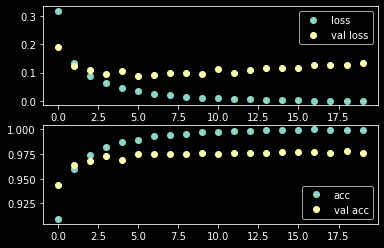

In [124]:
history = pd.DataFrame(training.history)

fig, ax = pyplot.subplots(2,1)
history['loss'].plot(ax=ax[0], style="o",label='loss')
history['val_loss'].plot(ax=ax[0], style="o",label='val loss')
ax[0].legend()
history['accuracy'].plot(ax=ax[1], style="o",label='acc')
history['val_accuracy'].plot(ax=ax[1], style="o",label='val acc')
ax[1].legend()

In [125]:
# Play Games with Reference NN Model
print("[+] Evaluate reference model \t>", end='', flush=True)
loss, accuracy  = evaluate_model(ml_model=ml_model, x = x_val, y=y_val)
print(f"\tAccuracy:{accuracy} | Loss:{loss} |")

625/625 [==============================] - 2s 3ms/step - loss: 0.1330 - accuracy: 0.9763
	Accuracy:0.9763000011444092 | Loss:0.1329822540283203 |


In [135]:
# >>>>>> Genetic Algorithm Section <<<<<<
print("\n********** Genetic Algorithm **********")
population = generate_first_population_randomly(
    population_size=POPULATION_SIZE
)


********** Genetic Algorithm **********
[+] Creating Initial NN Model Population Randomly: Done > Takes 0.0005981922149658203 sec


In [136]:
# Run Each Generation
generation_performance = {}
for current_generation in range(MAX_GENERATIONS):
    print(f"[+] Generation {current_generation+1} of {MAX_GENERATIONS}")

    # >>>>>> Training Phase <<<<<<
    print(f"\tTraining Models:", end='\n', flush=True)
    training_start = time.time()

    # Train all Models in Population
    for i,individual in enumerate(population):
        print(f"\t\tGenerating model for individual {i}", end='\n', flush=True)
        generate_model_from_chromosome(data, individual)

    training_stop = time.time()
    print(f"Done > Takes {training_stop - training_start} sec", end='\n')

    # >>>>>> Evaluation Phase <<<<<<
    print(f"\tEvaluating Population: ", end='\n', flush=True)
    evaluation_start = time.time()

    for i,individual in enumerate(population):
        print(f"\t\tIndividual {i}", end='\n', flush=True)
        

        # Play the Games
        loss, accuracy =  individual.ml_model.evaluate(x_val, y_val) 
        
        # Update Chromosome Results
        individual.loss = loss
        individual.accuracy = accuracy
        

    evaluation_stop = time.time()
    print(f"Done > Takes {evaluation_stop - evaluation_start} sec", end='\n')

    # Sort Candidates by Sum of Results
    population.sort(key=lambda x: x.accuracy, reverse=True)

    # Compute Generation Metrics
    generation_performance[current_generation] = pd.DataFrame([{'loss':x.loss, 'accuracy': x.accuracy} for x in population ])
    
    generation_performance[current_generation].describe()

    # >>>>>> Genetic Selection, Children Creation and Mutation <<<<<<
    population = evolve_population(population)

[+] Generation 1 of 3
	Training Models:
		Generating model for individual 0
		Generating model for individual 1
		Generating model for individual 2
		Generating model for individual 3
		Generating model for individual 4
Done > Takes 64.30428338050842 sec
	Evaluating Population: 
		Individual 0
625/625 [==============================] - 2s 3ms/step - loss: 1.1495 - accuracy: 0.6183
		Individual 1
625/625 [==============================] - 1s 2ms/step - loss: 0.7328 - accuracy: 0.8281
		Individual 2
625/625 [==============================] - 1s 2ms/step - loss: 0.3572 - accuracy: 0.8971
		Individual 3
625/625 [==============================] - 2s 2ms/step - loss: 1.9575 - accuracy: 0.3828
		Individual 4
625/625 [==============================] - 2s 3ms/step - loss: 2.0908 - accuracy: 0.6205
Done > Takes 8.064909934997559 sec
[+] Generation 2 of 3
	Training Models:
		Generating model for individual 0
		Generating model for individual 1
		Generating model for individual 2
		Generating mode

In [144]:
population[3].layer_layout[0].layer_type

'dropout'

In [130]:
[x.loss for x in population]

[0.5727636218070984,
 1.9533765316009521,
 0.9945458769798279,
 2.036054849624634,
 2.211662769317627]

In [132]:
pd.DataFrame([{'loss':x.loss, 'accuracy': x.accuracy} for x in population ]).describe()

,loss,accuracy
count,5.000000,5.000000
mean,1.553681,0.599550
std,0.724605,0.218946
min,0.572764,0.365150
25%,0.994546,0.382800
50%,1.953377,0.662750
75%,2.036055,0.720800
max,2.211663,0.866250
